In [ ]:
# Liver disease poses a significant health challenge globally, often leading to severe complications if not 
# diagnosed and managed early. Utilizing patient data to predict liver disease can transform healthcare practices 
# by enabling early intervention and personalized treatment plans. This business case centers around developing a 
# predictive model using patient data including demographic, lifestyle, and clinical variables to assess the risk 
# of liver disease. By analyzing attributes such as age, gender, BMI, and others, we can identify individuals at 
# high risk for liver disease. This model offers healthcare providers a tool to flag high-risk patients during 
# routine check-ups, allowing for timely diagnostic procedures and interventions.

In [ ]:
# Loading necessary libraries

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, f1_score, recall_score, accuracy_score
from sklearn.feature_selection import SelectFromModel
from summarytools import dfSummary
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [24]:
# Loading the dataset

df = pd.read_csv('Liver_disease_data.csv')
print(df.head())

   Age  Gender        BMI  AlcoholConsumption  Smoking  GeneticRisk  \
0   58       0  35.857584           17.272828        0            1   
1   71       1  30.732470            2.201266        0            1   
2   48       0  19.971407           18.500944        0            0   
3   34       1  16.615417           12.632870        0            0   
4   62       1  16.065830            1.087815        0            1   

   PhysicalActivity  Diabetes  Hypertension  LiverFunctionTest  Diagnosis  
0          0.658940         0             0          42.734240          1  
1          1.670557         1             0          67.309822          1  
2          9.928308         0             0          63.738956          0  
3          5.630129         0             0          64.555873          1  
4          3.566218         1             0          77.868689          1  


In [25]:
# PREPROCESSING THE DATA

In [26]:
# Gather an overview of the columns and their types
df.info()
# There seem to be no unnecessary columns to drop. An unnecessary column in this
# context would, for example, be the patient's ID

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1700 entries, 0 to 1699
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 1700 non-null   int64  
 1   Gender              1700 non-null   int64  
 2   BMI                 1700 non-null   float64
 3   AlcoholConsumption  1700 non-null   float64
 4   Smoking             1700 non-null   int64  
 5   GeneticRisk         1700 non-null   int64  
 6   PhysicalActivity    1700 non-null   float64
 7   Diabetes            1700 non-null   int64  
 8   Hypertension        1700 non-null   int64  
 9   LiverFunctionTest   1700 non-null   float64
 10  Diagnosis           1700 non-null   int64  
dtypes: float64(4), int64(7)
memory usage: 146.2 KB


In [27]:
# Print all categorical and umerical columns
cont_cols = df.select_dtypes('number').columns
obj_cols = df.select_dtypes(object).columns
print(f'Object cols: {obj_cols}')
print(f'Continuous Cols: {cont_cols}')
# This reveals that there are no categorical columns to handle, as all
# columns got encoded already 

Object cols: Index([], dtype='object')
Continuous Cols: Index(['Age', 'Gender', 'BMI', 'AlcoholConsumption', 'Smoking', 'GeneticRisk',
       'PhysicalActivity', 'Diabetes', 'Hypertension', 'LiverFunctionTest',
       'Diagnosis'],
      dtype='object')


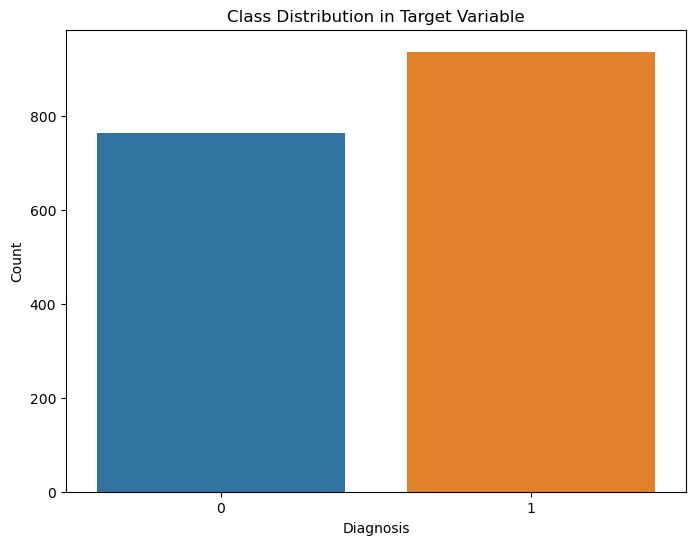

Class Proportions (%):
1    55.058824
0    44.941176
Name: Diagnosis, dtype: float64
Minority class proportion: 44.94%
The dataset is relatively balanced.
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.4s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   1.1s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_d

In [22]:
# Check whether the dataset is imbalanced

# Define target variable
y = df['Diagnosis']

# Visualize Class Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=y)
plt.title('Class Distribution in Target Variable')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.show()

# Calculate Class Proportions
class_proportions = y.value_counts(normalize=True) * 100
print("Class Proportions (%):")
print(class_proportions)

# Check if dataset is imbalanced
minority_class_proportion = class_proportions.min()
print(f"Minority class proportion: {minority_class_proportion:.2f}%")

if minority_class_proportion < 10:
    print("The dataset is imbalanced.")
else:
    print("The dataset is relatively balanced.")

In [31]:
# Get a broader overview over the columns of the dataset

dfSummary(df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Age[int64],Mean (sd) : 50.4 (17.6)min < med < max:20.0 < 51.0 < 80.0IQR (CV) : 31.0 (2.9),61 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACnElEQVR4nO3dQYriQBSA4VdjK1EhQbrRnRcYmIVLDzGHnSOM4Am8gTtBJGKmgzFmVrNrY1KVTOrF/9tKNNg/lVfVNG2KohDAd9+6vgGgireubwD9YYwZi8jI8vJrURSfj14kVDTCGDN+f3//GYbhzOb68/l8Msb8ehQroaIpozAMZ+v1+jOKorTOhXEcB9vtdnY8HkciQqgo5/joDu/3+zCKotN8Pv9jcf247EVCfaDNectHro/uLMuCPM+/p2n6W0RsQi1FqF9oe97ylPWjW0Rkv9/Pdrvd5Ha7Ddq4OUL9mtO8tdls5sfj8cMYc7b47E5X4yiKUptH9+l0Kn10uyLUEjY/tCRJhlmW/Vgul4PBYFB7ZVK6GrfuaaivNqu5ul6vb0EQTFarVbpYLE51rq2y+31VpaG+6KzWiOl0avUIlSe731f1bEVt9WwMqKrSjGo7YAurAxrS281UE4fXTd4P3PQyVN8Pr8vkeT4UkdAYY/sWvdzAthpqh1+614fXj7gebYn0dwPbWqg+fOm+Hl4/4nK0JeL8ywavx53WQm3iS3/VUwPboy2XxaHLcaeK1mdUh/NEEU4NanFZHLoad6rq5Wbq1dksDl2NO1V5HarDZszreQv1eRtqn+ct1OdtqH2et1Cft6H+08d5C/Xxd/1QgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKECoUIFQoUKhAoVCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKECoUIFQoUKlf5pbxzHQd03vlwugYhIkiTB4XCY/M/rtX621vt2vb5KX38Bdjm2kyrTHHkAAAAASUVORK5CYII="">",0(0.0%)
2,Gender[int64],1. 12. 0,857 (50.4%)843 (49.6%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABN0lEQVR4nO3bwYnDMBRF0a8gwmQjYQwuxkVMsSlC3RhjLZKQjWYxDcR/8YTIPRV8zMWQ4BdaawYoBDO7mdm19yEDerfWnr2PGEmc5/k3pTT1PmQ0tdY9hHAnuM/FlNK0rusz5/zqfcwojuP4KaVM27ZdzYzYPhTNzHLOr2VZHr2PGcyt9wGjufQ+AN+D2CBDbJAhNsgQG2SIDTLEBhligwyxQYbYIENskCE2yBAbZIgNMsQGmWj2/zFg70NGwvPyibXWvZQyGR8DnlJr3c3s3fuOkTB48WPwclJgygcV3mw+vNUcmPI5MOPzYcp3EjM+P6Z8Pvxyd+BPXcgQG2SIDTLEBhligwyxQYbYIENskCE2yBAbZIgNMsQGGWKDDLFBhtggw5TvJJ6VH1M+B2Z8PgxefBi8OPwBCltq31np+ZoAAAAASUVORK5CYII="">",0(0.0%)
3,BMI[float64],Mean (sd) : 27.7 (7.2)min < med < max:15.0 < 27.9 < 40.0IQR (CV) : 12.5 (3.8),"1,700 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACrElEQVR4nO3bO0/bUByG8f9pIDoQ1VYuIpu/AFIHJBaWbh37Ybt265BInfkGLAgJJY7iYsWYdEFqK9HElxj7hec3c+IzPDoXW7jtdmtA131oewJAEUdtTwDd4Zw7MbN+jZ/YbLfbh0PN52+E+sbUiM2PRqMvYRgOqj57tVotnHPfmoiVUN8Q59zJeDz+GgTBsOzYLMu8mZ1fXl7+nEwmq7Lj4zj2s9lseH9/3zczQsVO/SAIhldXVw9hGKZlBt7c3Ayvr69PvffZ2dnZr4rPP6k4bi9C/Y+a57XGzmpFhGGYlo1tsVg0FtkhEOoL6myhZmbL5XLtnPtuZqVWtWetRt5VhPqyylvo7e3tx/l8/jmKokmv1ysdapMXEmV7Q1XeAuuquoV6708vLi7S6XS6KDO26QuJsp2h1t0C3/PqMBgMSkf+rNNnxbbsW1Erb4GsDjikQmfUKlvgM1YHHESnL1Pv+XyMf3U21JZfEQVPT0/HVZ5bV57nx2YWOOeqDG9t3ma1575zYelsqNbiK6Isy3ye5+dpmv4ws6pfaUpLkuQ4y7JPURT1lOZtVn/u+y7eXQ7VzF7/FZHZn8+Jj4+PvbJj69hsNkeK8zarN/ciF+9GQ217G6v6iqjtz4mq8zZr7rVcY6Eqb2PonsZCVd7G0D2Nn1GVtzF0B/8zBQmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECglHRf4ojmNf9ofX67U3M0uSxN/d3Z2+5njVZ6vOu+74In39BhCrjvsxQo8cAAAAAElFTkSuQmCC"">",0(0.0%)
4,AlcoholConsumption[float64],Mean (sd) : 9.8 (5.8)min < med < max:0.0 < 9.8 < 20.0IQR (CV) : 10.0 (1.7),"1,700 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACy0lEQVR4nO3YvW4aQRSG4TMBzALOrjAIOm7AUgpLbmjSpczFpk1nJCOl9h3QICTEjyBGrIEUiaIUDuzssDGf8j41s4xG7x7scYfDwYBL9+6tNwBkUS7y4c65mpldBTxiezgcns+1H+gqLFTnXK3Van2O47iZ9xnL5XLmnPtCrNkFDoeLHQxFTtSrOI6b/X7/OUmSje/ixWIRDQaDznQ6bTvnljm+/2IPvSihw+GSB8PJUAPe0Hi/31eSJJl1Op3vvovX63UlTdMPvV6vVCqVvEOfz+cr59xXM/Ne+8ubhB44EePr6+tOv99f+g6HMwwGswLP7GioIW9omqbRbre73Ww2D2bmHep2uy1HUVS/u7vbdLvdmc

/var/folders/ny/dgv2cxy93lscgz7f9cxb4br40000gn/T/ipykernel_30139/3991723992.py:14: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=data, x=col, ax=axes[i], hue=hue, palette=palette, fill=True)


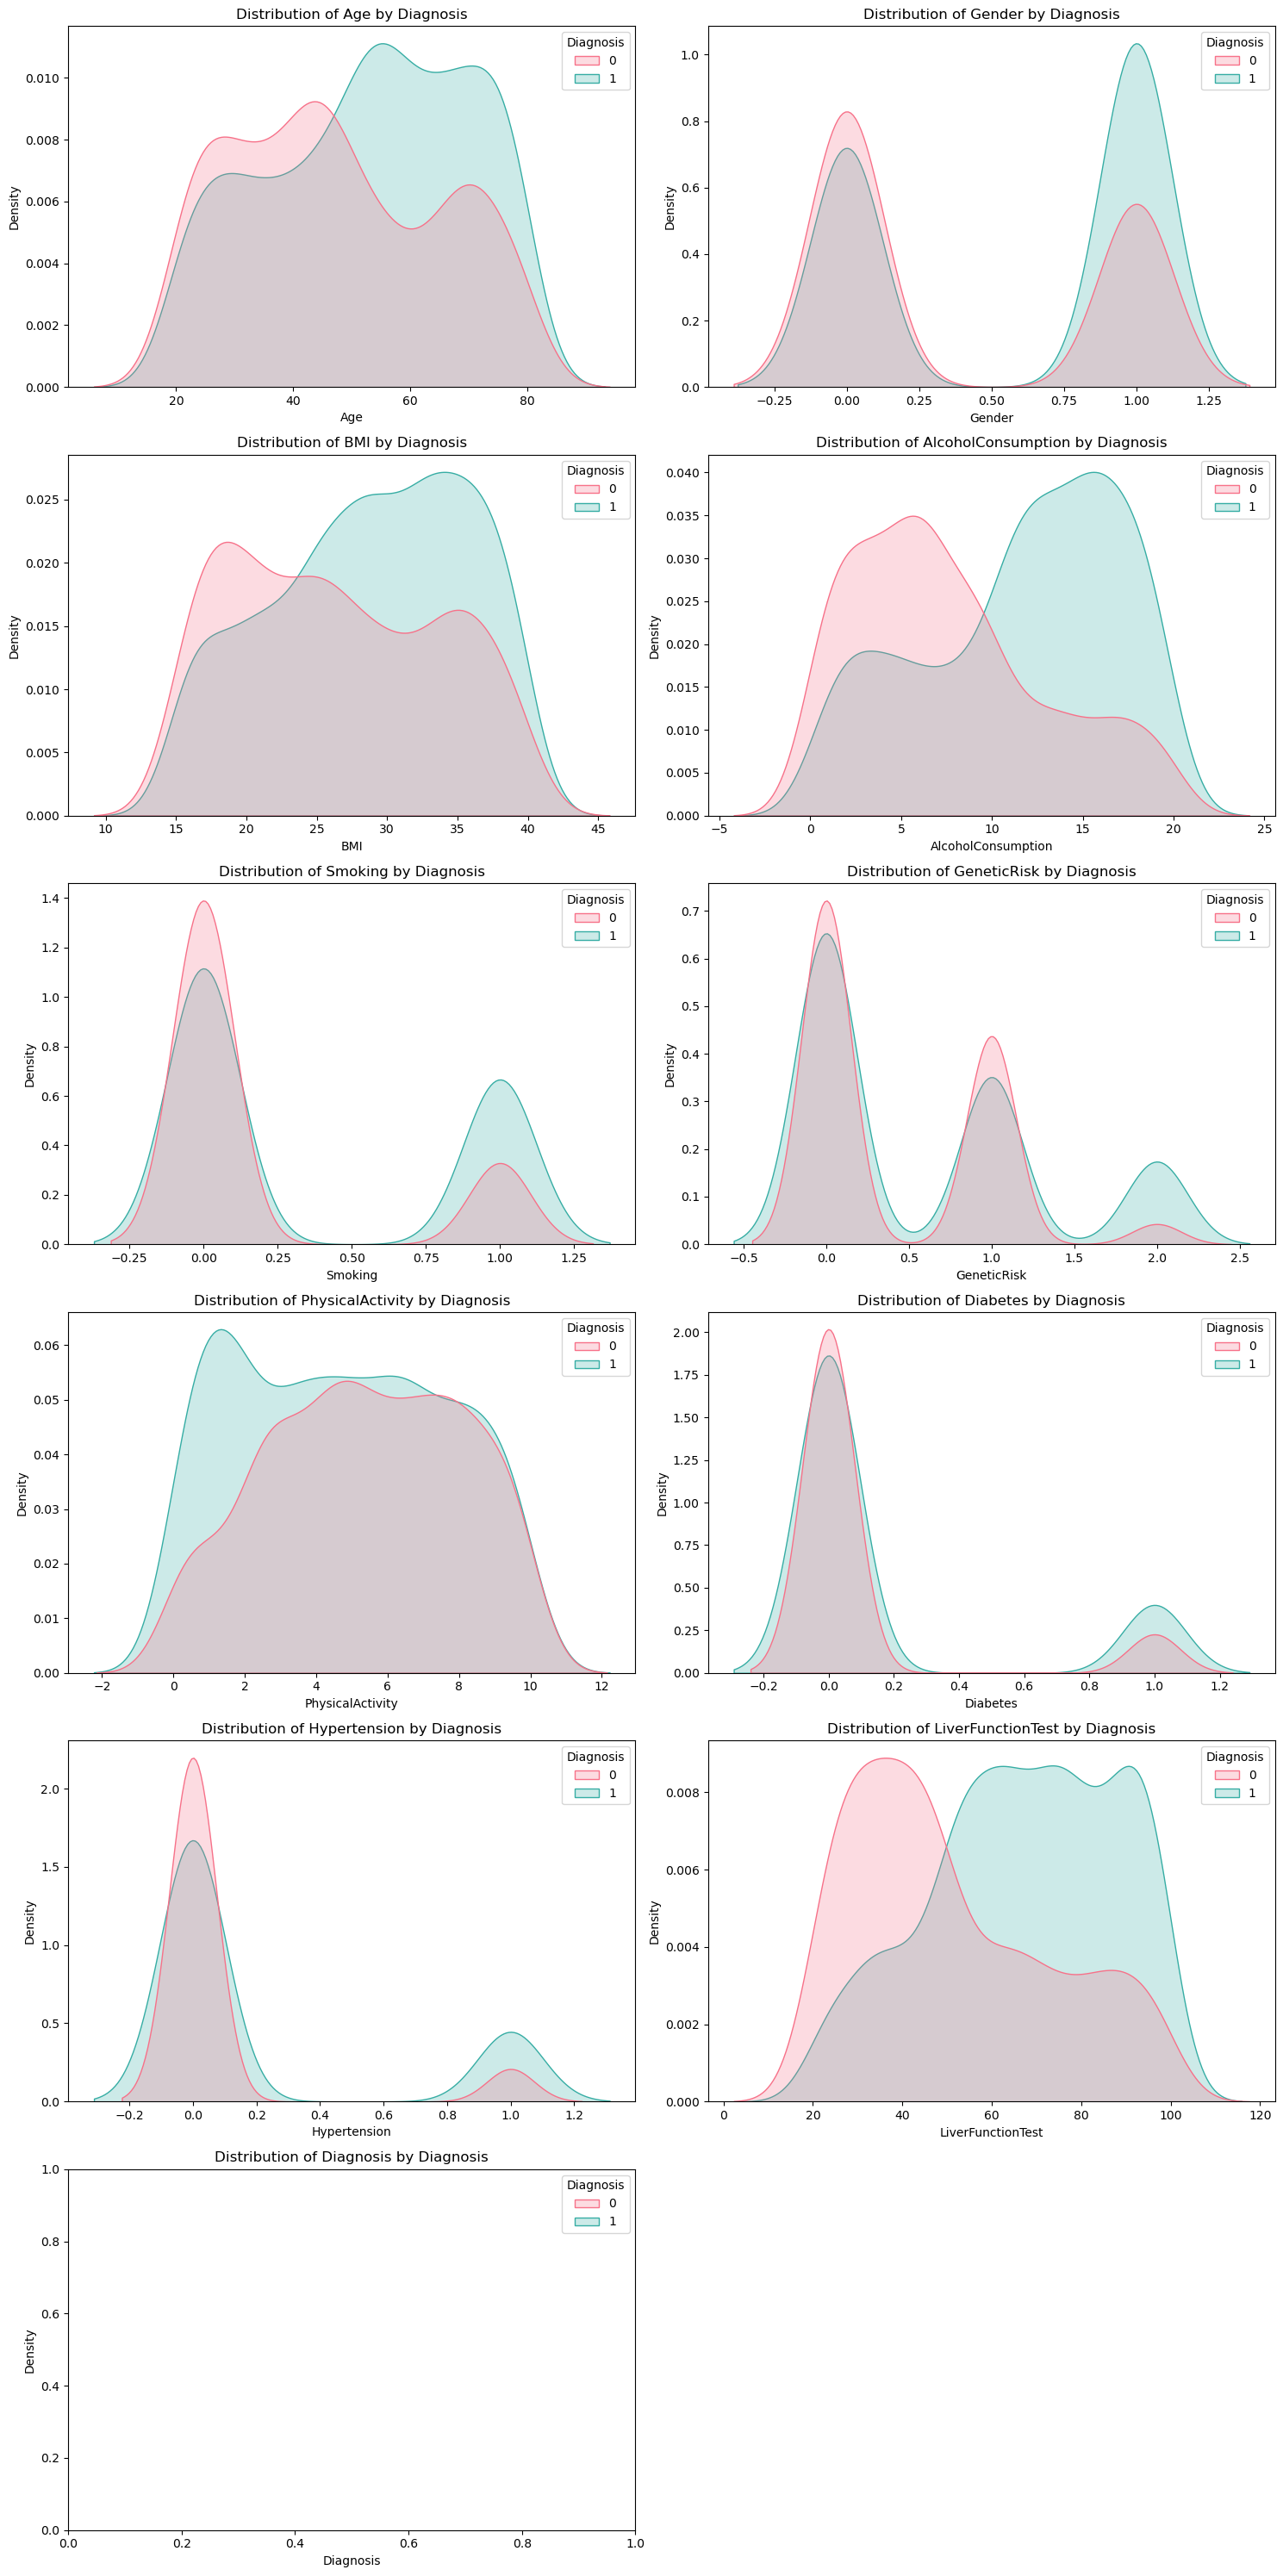

In [ ]:
# Visualization Function 
# This function, plot_kde, generates Kernel Density Estimate (KDE) plots for each
# numerical column in the dataset in relation to the 'Diagnosis' column. It creates
# a grid of subplots to visualize the distribution of each feature, allowing for
# a clear comparison between different diagnosis categories. The function uses
# Seaborn's kdeplot to plot the distributions and Matplotlib for the subplot layout

def plot_kde(data, cols, hue, palette):
    num_cols = len(cols)
    fig, axes = plt.subplots(nrows=(num_cols + 1) // 2, ncols=2, figsize=(15, 5 * ((num_cols + 1) // 2)))
    axes = axes.flatten()
    
    for i, col in enumerate(cols):
        sns.kdeplot(data=data, x=col, ax=axes[i], hue=hue, palette=palette, fill=True)
        axes[i].set_title(f'Distribution of {col} by {hue}')
    
    # Remove empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

# Call the function
plot_kde(df, cont_cols, 'Diagnosis', sns.color_palette("husl", df['Diagnosis'].nunique()))

In [ ]:
# CREATE ML MODELS

In [29]:
# Define target (Diagnosis) as y and all remaining columns as X
X = df.drop(columns=['Diagnosis'], axis=1)
y = df['Diagnosis'].values

# Split the dataset into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

Accuracy:  0.6752941176470588
Confusion matrix:
[[119  75]
 [ 63 168]]
Recall: [0.61340206 0.72727273]
F1 score: 0.6742228418434436


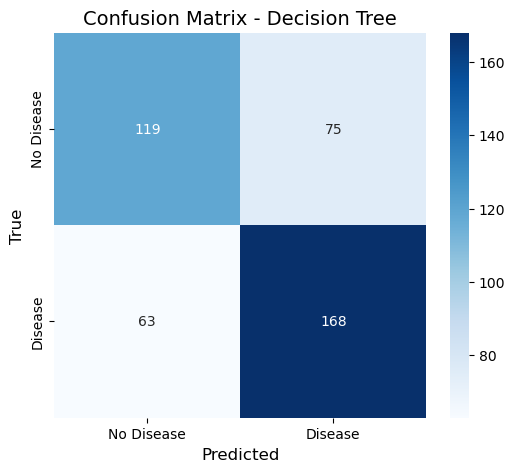

In [41]:
# DECISION TREE

# Create a decision tree classifier with max_depth of 2
clf = DecisionTreeClassifier(max_depth=2)

# Train the decision tree classifier on the training data
clf.fit(X_train, y_train)

# Predict the classes of the testing data using the trained classifier
y_pred = clf.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = clf.score(X_test, y_test)
print("Accuracy: ", accuracy)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:")
print(cm)

# Calculate the recall for each class
recall = recall_score(y_test, y_pred, average=None)
print("Recall:", recall)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 score:", f1)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
plt.title('Confusion Matrix - Decision Tree', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [42]:
# The above metrics are fine, but not super good. Let's try to improve them.
# For this, we introduced hyperparameter tuning using GridSearchCV for the Decision Tree Classifier. 
# GridSearchCV systematically explores a predefined grid of hyperparameters, such as max_depth, min_samples_split, 
# and min_samples_leaf, by training the model with different combinations. It uses cross-validation to evaluate 
# the performance for each set of parameters and selects the combination that optimizes the model's accuracy. 
# This process enhances the model's performance by identifying the best hyperparameters, thereby improving its 
# generalization ability and predictive accuracy on the test data.

# Split the dataset into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Decision Tree Classifier with Hyperparameter Tuning
param_grid = {
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

clf = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring='accuracy')
clf.fit(X_train, y_train)

# Best Parameters
print("Best parameters:", clf.best_params_)

# Predict the classes of the testing data using the trained classifier
y_pred = clf.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = clf.score(X_test, y_test)
print("Accuracy: ", accuracy)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:")
print(cm)

# Calculate the recall for each class
recall = recall_score(y_test, y_pred, average=None)
print("Recall:", recall)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 score:", f1)

Best parameters: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2}
Accuracy:  0.8470588235294118
Confusion matrix:
[[163  31]
 [ 34 197]]
Recall: [0.84020619 0.85281385]
F1 score: 0.8471457466191933


In [ ]:
# The results showed an improvement in the classifier's metrics, achieving an accuracy of 84.71%, a recall of 
# 84.02% for the negative class, and 85.28% for the positive class, and a weighted F1 score of 84.71%. The 
# confusion matrix indicated that the classifier correctly predicted the majority of instances, with 163 true 
# negatives and 197 true positives, while misclassifying 31 instances as false positives and 34 as false negatives.
# This tuning process improved the model's ability to generalize from the training data and provided better 
# predictive performance on the test data.

In [34]:
# DECISION TREE WITH L1

# In this approach, we used a Decision Tree classifier with L1-based feature selection, which is a method for 
# reducing the number of input features by selecting only the most relevant ones. L1 regularization 
# here involves using SelectFromModel to evaluate and select features based on their importance as determined by a 
# Decision Tree. The key difference from a standard Decision Tree is that this method first reduces the 
# dimensionality of the data by selecting a subset of features, which can enhance the model's performance and 
# interpretability by focusing on the most significant predictors. This preprocessing step can help avoid 
# overfitting and improve generalization on unseen data by eliminating less important or redundant features before 
# training the Decision Tree.

# Split the dataset into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Create the decision tree classifier
dt = DecisionTreeClassifier()

# Create a feature selection model with L1 regularization
l1_selector = SelectFromModel(estimator=dt, threshold='median')

# Fit the feature selection model to the training data
X_train_selected = l1_selector.fit_transform(X_train, y_train)

# Apply the same feature selection to the testing data
X_test_selected = l1_selector.transform(X_test)

# Fit the decision tree classifier on the selected features
dt.fit(X_train_selected, y_train)

# Make predictions on the testing data
y_pred = dt.predict(X_test_selected)

# Calculate accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate the recall for each class
recall = recall_score(y_test, y_pred, average=None)
print("Recall:", recall)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 score:", f1)

Accuracy: 0.7035294117647058
Recall: [0.68556701 0.71861472]
F1 score: 0.703747385417049


In [35]:
# RANDOM FOREST

# As we saw can Hyperparameter tuning improve the metrics significantly. Therefore, we chose to perform gridsearch
# for the random forest as well.

# Split the dataset into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Random Forest Classifier with Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200, 300],           # Number of trees in the forest
    'max_depth': [5, 10, 15],                  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],           # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],             # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]                 # Method of selecting samples for training each tree
}

rf = RandomForestClassifier(random_state=0)

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Best model
best_rf = grid_search.best_estimator_

# Predictions
y_pred = best_rf.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:")
print(cm)

# Recall for each class
recall = recall_score(y_test, y_pred, average=None)
print("Recall:", recall)

# F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 score:", f1)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best parameters: {'bootstrap': False, 'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Accuracy: 0.9035294117647059
Confusion matrix:
[[174  20]
 [ 21 210]]
Recall: [0.89690722 0.90909091]
F1 score: 0.9035487780756565


In [ ]:
# The Random Forest classifier achieved an accuracy of 90.35% with the best parameters: bootstrap=False, 
# max_depth=15, min_samples_leaf=2, min_samples_split=5, and n_estimators=300. It showed a balanced performance 
# with a recall of 89.69% for class 0 and 90.91% for class 1, and a weighted F1 score of 90.35%. The confusion 
# matrix indicated 174 true negatives, 210 true positives, 20 false positives, and 21 false negatives, 
# demonstrating effective prediction for liver disease.

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Accuracy: 0.9011764705882352
Confusion matrix:
Recall: [0.90721649 0.8961039 ]
F1 score: 0.9012787792113908


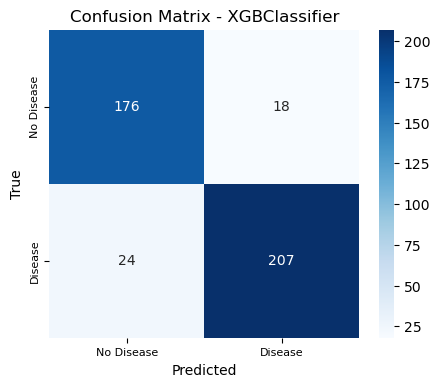

In [36]:
# XGBOOST

# Split the dataset into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# XGBoost Classifier with Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200, 300],            # Number of boosting rounds
    'max_depth': [3, 6, 9],                     # Maximum tree depth
    'learning_rate': [0.01, 0.1, 0.2],          # Step size shrinkage
    'subsample': [0.8, 1.0],                    # Fraction of samples for each boosting round
    'colsample_bytree': [0.8, 1.0],             # Fraction of features for each boosting round
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0)

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Best model
best_xgb = grid_search.best_estimator_

# Predictions
y_pred = best_xgb.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:")

# Recall for each class
recall = recall_score(y_test, y_pred, average=None)
print("Recall:", recall)

# F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 score:", f1)

In [37]:
# ADA BOOST

# Split the dataset into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Create an AdaBoost classifier with decision tree as base estimator
adaboost_clf = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), random_state=42)

# Specify the grid of hyperparameters to search
param_grid = {'n_estimators': [10, 50, 100, 200], 'learning_rate': [0.1, 0.5, 1, 2]}

# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(adaboost_clf, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and corresponding accuracy
print("Best hyperparameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

# Make predictions on the test data using the best estimator
best_adaboost_clf = grid_search.best_estimator_
y_pred = best_adaboost_clf.predict(X_test)

# Calculate F1 score and recall
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the F1 score and recall
print("F1 Score:", f1)
print("Recall:", recall)

# Additionally, you might want to print the accuracy on the test set
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", test_accuracy)

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

Best hyperparameters: {'learning_rate': 0.1, 'n_estimators': 100}
Best cross-validation accuracy: 0.9152941176470588
F1 Score: 0.9154013015184382
Recall: 0.9134199134199135
Test Accuracy: 0.908235294117647
Confusion Matrix:
 [[175  19]
 [ 20 211]]


In [38]:
# VOTING CLASSIFIER

# Split the dataset into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Create three different classifiers
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
knn_clf = KNeighborsClassifier(n_neighbors=3)
adaboost_clf = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=50, learning_rate=1, random_state=42)

# Create a voting classifier with the three classifiers
voting_clf = VotingClassifier(estimators=[('tree', tree_clf), ('knn', knn_clf), ('adaboost', adaboost_clf)], voting='hard')

# Specify the grid of hyperparameters to search
param_grid = {'tree__max_depth': [2, 4, 6], 'knn__n_neighbors': [3, 5, 7], 'adaboost__n_estimators': [10, 50, 100], 'adaboost__learning_rate': [0.1, 0.5, 1, 2]}

# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(voting_clf, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and corresponding accuracy
print("Best hyperparameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

# Make predictions on the test data using the best estimator
best_voting_clf = grid_search.best_estimator_
y_pred = best_voting_clf.predict(X_test)

# Calculate accuracy, F1 score, and recall
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the accuracy, F1 score, and recall
print("Test Accuracy:", accuracy)
print("F1 Score:", f1)
print("Recall:", recall)

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

Best hyperparameters: {'adaboost__learning_rate': 0.1, 'adaboost__n_estimators': 100, 'knn__n_neighbors': 7, 'tree__max_depth': 6}
Best cross-validation accuracy: 0.8862745098039216
Test Accuracy: 0.8776470588235294
F1 Score: 0.8828828828828829
Recall: 0.8484848484848485
Confusion Matrix:
 [[177  17]
 [ 35 196]]


In [39]:
# NEURAL NETWORK

# Split the dataset into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Convert data to NumPy arrays
# This step converts the training features to NumPy arrays for compatibility with Keras
X_train_new = np.array(X_train)
X_test_new = np.array(X_test)

# One-hot encode the labels 
# This converts the categorical labels into a binary matrix (one-hot encoding), necessary for categorical_crossentropy
y_train_new = to_categorical(y_train, num_classes=2)
y_test_new = to_categorical(y_test, num_classes=2)

# Define the hyperparameters for sensitivity analysis
learning_rates = [0.01, 0.1, 0.001]
hidden_units = [8, 16, 32]

# Perform sensitivity analysis for hyperparameters
# This loop iterates over all combinations of learning rates and hidden units
for learning_rate in learning_rates:
    for units in hidden_units:
        # Create the neural network model
        # Sequential model means layers are added sequentially
        model = Sequential()

        # Add the input layer
        # Input layer to define the shape of the input data
        model.add(Input(shape=(X_train_new.shape[1],)))

        # Add a hidden layer
        model.add(Dense(units, activation='relu'))

        # Add the output layer
        # Dense layer with 2 neurons (for binary classification) and softmax activation function
        # Softmax outputs a probability distribution over 2 classes
        model.add(Dense(2, activation='softmax'))

        # Compile the model
        # Adam optimizer with specified learning rate
        # Categorical crossentropy loss function for multi-class classification
        model.compile(optimizer=Adam(learning_rate=learning_rate),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        # Train the model
        # Fit the model to the training data
        # 'epochs' is the number of times the learning algorithm will work through the entire training dataset
        # 'batch_size' specifies the number of samples per gradient update
        # 'verbose=0' silences the output during training
        model.fit(X_train_new, y_train_new, epochs=50, batch_size=8, verbose=0)

        # Evaluate the model on the test data
        loss, accuracy = model.evaluate(X_test_new, y_test_new, verbose=0)

        # Predict on the test data
        y_pred_prob = model.predict(X_test_new)
        y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class labels

        # Calculate recall and F1 score
        recall = recall_score(np.argmax(y_test_new, axis=1), y_pred)
        f1 = f1_score(np.argmax(y_test_new, axis=1), y_pred)

        # Print the results
        print(f"Learning Rate: {learning_rate:.3f}, Hidden Units: {units}, Test Accuracy: {accuracy:.3f}, Recall: {recall:.3f}, F1 Score: {f1:.3f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Learning Rate: 0.010, Hidden Units: 8, Test Accuracy: 0.819, Recall: 0.771, F1 Score: 0.822
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Learning Rate: 0.010, Hidden Units: 16, Test Accuracy: 0.824, Recall: 0.848, F1 Score: 0.839
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Learning Rate: 0.010, Hidden Units: 32, Test Accuracy: 0.791, Recall: 0.645, F1 Score: 0.770
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Learning Rate: 0.100, Hidden Units: 8, Test Accuracy: 0.456, Recall: 0.000, F1 Score: 0.000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Learning Rate: 0.100, Hidden Units: 16, Test Accuracy: 0.456, Recall: 0.000, F1 Score: 0.000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Learning Rate: 0.100, Hidden Units: 32, Test Accuracy: 0.544, Recall: 1.000, F1 Score: 0.704
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Learning Rate: 0.001, Hidden Units: 8, Test Accuracy: 0.755, Recall: 0.671, F1 Score: 0.749
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Learning Rate: 0.001, Hidden Unit

In [ ]:
# For the neural network on this liver disease dataset, a learning rate of 0.01 and 8 hidden units provide the 
# best accuracy. This indicates that a smaller, simpler model with careful learning rate tuning is more effective 
# than more complex models or higher learning rates

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5449 - loss: 1.5373 - val_accuracy: 0.6745 - val_loss: 0.6109
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6754 - loss: 0.5961 - val_accuracy: 0.7137 - val_loss: 0.5634
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7019 - loss: 0.5643 - val_accuracy: 0.6510 - val_loss: 0.6411
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7013 - loss: 0.5805 - val_accuracy: 0.7333 - val_loss: 0.5419
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7154 - loss: 0.5464 - val_accuracy: 0.6980 - val_loss: 0.6018
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7218 - loss: 0.5403 - val_accuracy: 0.6941 - val_loss: 0.5772
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7219 - loss: 0.5217 - val_accuracy: 0.7490 - val_loss: 0.5208
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7249 - loss: 0.5357 - val_accuracy: 0.6902 - val_loss:

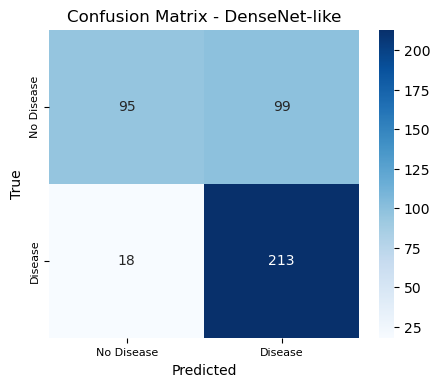

Recall: 0.922
F1 Score: 0.785


In [6]:
# DEEP NEURAL NETWORK

# We constructed this DenseNet-like Deep Neural Network as neural network adapted from Dense Convolutional Networks
# (DenseNet), characterized by its dense connections, where each layer receives inputs from all preceding layers. 
# This design allows for effective feature reuse, making it particularly suitable for complex pattern recognition 
# in structured tabular data. The network is composed of multiple dense layers with skip connections that enhance f
# eature propagation, enabling the model to capture intricate relationships within the data. This architecture is 
# compiled with an Adam optimizer and binary cross-entropy loss, making it well-suited for binary classification 
# tasks like diagnosing liver disease from tabular datasets.

# Split the dataset into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Input layer
# Input shape is determined by the number of features in the training data
input_layer = Input(shape=(X_train.shape[1],))

# Dense layers with dense connections (skip connections)
# First dense layer
x = Dense(64, activation='relu')(input_layer)

# First skip connection
x1 = Dense(64, activation='relu')(x)
x = concatenate([x, x1])  # Combine input and output for skip connection

# Second dense layer
x = Dense(128, activation='relu')(x)

# Second skip connection
x1 = Dense(128, activation='relu')(x)
x = concatenate([x, x1])  # Another skip connection

# Third dense layer
x = Dense(64, activation='relu')(x)

# Third skip connection
x1 = Dense(64, activation='relu')(x)
x = concatenate([x, x1])  # Final skip connection

# Output layer
# Uses sigmoid activation to output a probability for binary classification
output_layer = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
# Adam optimizer is used for its efficiency
# Binary cross-entropy is used as the loss function suitable for binary classification
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
# Fit the model with training data
# `validation_split` is used to monitor model performance on a subset of the training data
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.3f}")

# Predict on the test data
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # Threshold the probabilities to get class predictions

# Calculate and print the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:")
print(cm)

# Calculate additional metrics
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

In [22]:
# COMPARE METRICS OF ALL MODELS 

# Decision Tree:
    # Accuracy: 0.68
    # Recall: 0.73
    # F1 score: 0.67
    
# Decision Tree with GridSearch: 
    # Accuracy:  0.85
    # Recall: 0.85
    # F1 score: 0.85
    
# Decision Tree with L1:
    # Accuracy: 0.71
    # Recall: 0.73
    # F1 score: 0.71

# Random Forest:
    # Accuracy: 0.9
    # Recall: 0.91
    # F1 score: 0.9
    
# XGBoost:
    # Accuracy: 0.68
    # Recall: 0.72
    # F1 score: 0.68
    
# Ada Boost:
    # Accuracy: 0.91
    # Recall: 0.91
    # F1 Score: 0.92

# Voting Classifier:
    # Accuracy: 0.88
    # Recall: 0.85
    # F1 Score: 0.88
    
# Neural Network: (Iteration with highest accuracy)
    # Accuracy: 0.83,
    # Recall: 0.81
    # F1 Score: 0.84

# Deep Neural Network:
    # Accuracy: 0.73
    # Recall: 0.92
    # F1 Score: 0.79
    

# ADA BOOST delivered the best predicition results

In [ ]:
# The AdaBoost model achieved an impressive performance in predicting liver disease, with an accuracy of 91%, a 
# recall of 91%, and an F1 score of 92%. Accuracy indicates that 91% of the predictions made by the model were 
# correct, demonstrating its overall reliability. The recall score of 91% reflects the model's effectiveness in 
# identifying patients who truly have liver disease, which is crucial for ensuring that high-risk individuals are 
# not overlooked. The F1 score, which balances precision and recall, stands at 92%, indicating a strong harmony 
# between correctly identifying both liver disease patients and those without the condition. This high performance 
# supports the business case by highlighting the model's potential to reliably assist healthcare providers in 
# early detection and accurate diagnosis of liver disease. By integrating this model into routine clinical 
# workflows, healthcare providers can proactively identify at-risk patients, enabling timely interventions, 
# personalized care, and improved patient outcomes, while also optimizing healthcare resource utilization.